# Challenge

Must-haves (mandatory)

We give you several options, but we ask you to select only 2 that you consider are the
most valuable using the data at hand.

1. Can you design a code that detects those clients who are not going to fulfill the
contractual conditions?

- How should the data be prepared in order to extract more and better
information about our customers? Which treatments and methodologies
do you propose? What new variables may you create to know more about
the client?

- Our PO is worried about the costs of offering our product to a customer
that does not fulfill the contractual conditions. Which is the best metric to
measure the quality of the results? What do you recommend?

- How can you prove that any model that you develop is not capturing noise?
If you were auditing your own model from an outsider perspective, how
would you determine whether or not the model is robust?

2. To which customers should each product be offered? Can you identify which
customers are more likely to contract one of the two categories of products? Do
you detect any interesting group of customers?

3. As you can see in the description of the variables below, we have three scores
(reactive, proactive and behavioral) provided by the risk department. These scores
are useful, but are calculated only for those clients that meet certain
characteristics defined by the risk department. As you will notice, they are not
defined for all the clients of the dataset. We want to develop an estimate for these
clients based on the clients who own this value. Can you develop a simple

4. Currently the products are offered only to customers whose salaries are paid into
a BBVA account. Our business partners are considering extending the product
offering to more clients, even if they haven’t set up a direct salary deposit with us.
Indeed, we think that it is viable to create a salary estimator for customers for
whom we do not have demographic and financial data. Is this possible?

### Librerias

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import os 

# Graficos
# =============================================================================
import seaborn as sns
import matplotlib.pyplot as plt

# Algoritmos
# =============================================================================
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from scipy.stats import skew
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split,StratifiedKFold
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score,mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Otros
# =============================================================================
from PIL import Image
import joblib

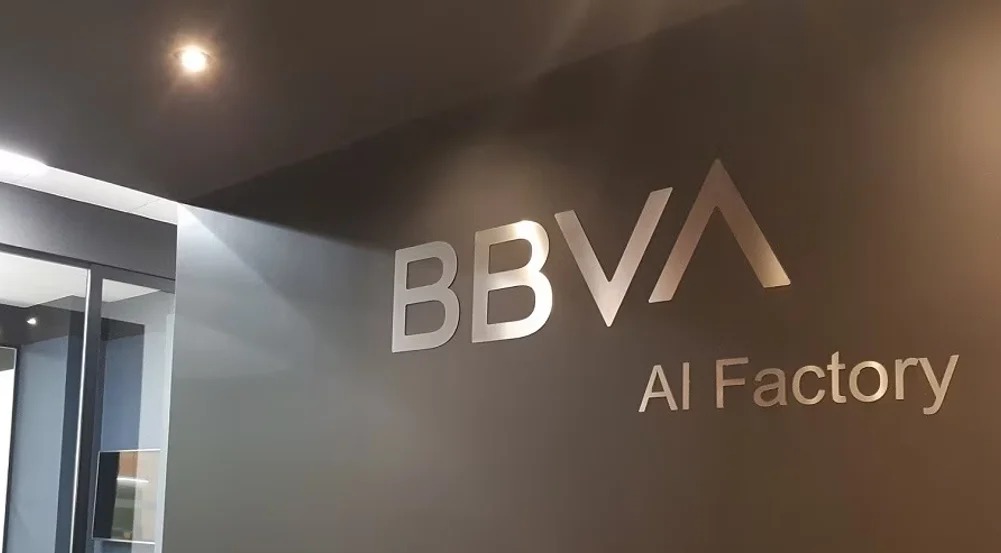

In [2]:
base_path = os.getcwd()  
root_path = os.path.dirname(base_path)  
image_path = os.path.join(root_path, "image", "bbva.png")  

# Abrir imagen con Pillow
img = Image.open(image_path)

# Mostrar imagen dentro del notebook
display(img)

#### Parameters

In [3]:
input_data = r'C:\wokspace_github\Data\input_data'

In [4]:
output_data = r'C:\wokspace_github\Data\output_data'

In [5]:
clientes = 'CLIENTS.csv'

In [6]:
comportamiento = 'BEHAVIOURAL.csv'

In [7]:
%run config.py

## Detección de clientes que no cumplirán condiciones contractuales

**1. Información de clientes y comportamiento**

- Información de cliente

In [8]:
df_clientes = load_client_data(input_data, clientes, dtypes_clientes)

In [9]:
cliente = df_clientes['CLIENT_ID'].duplicated().any()
print(f"¿Existen duplicados de cliente en la tabla de clientes? {cliente}")

¿Existen duplicados de cliente en la tabla de clientes? False


In [10]:
df_clientes.shape

(162977, 45)

In [11]:
num_clientes_unicos = df_clientes['CLIENT_ID'].nunique()
print(f"Número de clientes únicos: {num_clientes_unicos}")

Número de clientes únicos: 162977


- Información de comportamiento

In [12]:
df_comportamiento = load_client_data(input_data, comportamiento, dtypes_comportamiento)

In [13]:
clientes_duplicados_key = df_comportamiento.duplicated(subset=['CLIENT_ID', 'DATE','CONTRACT_ID'], keep=False).any()
print(f"¿Existen duplicados de cliente en la tabla de comportamiento? {clientes_duplicados_key}")

¿Existen duplicados de cliente en la tabla de comportamiento? False


In [14]:
df_comportamiento.shape

(1724854, 14)

In [15]:
num_clientes_unicos = df_comportamiento['CLIENT_ID'].nunique()
print(f"Número de clientes únicos: {num_clientes_unicos}")

Número de clientes únicos: 46046


In [16]:
df_comportamiento["DATE"] = pd.to_datetime(df_comportamiento["DATE"])

In [17]:
df_comportamiento['MONTH'] = df_comportamiento['DATE'].dt.month

In [18]:
agg_funcs = {
    "CREDICT_CARD_BALANCE": ["mean", "max","min"],
    "CREDIT_CARD_LIMIT": ["mean", "max","min"],
    "CREDIT_CARD_DRAWINGS_ATM": ["sum"],
    "CREDIT_CARD_DRAWINGS": ["sum"],
    "CREDIT_CARD_DRAWINGS_POS": ["sum"],
    "CREDIT_CARD_DRAWINGS_OTHER": ["sum"],
    "CREDIT_CARD_PAYMENT": ["sum"],
    "NUMBER_DRAWINGS_ATM": ["mean", "max","min"],
    "NUMBER_DRAWINGS": ["mean", "max","min"],
    "NUMBER_INSTALMENTS": ["mean", "max","min"],
    "MONTH": ["min", "max"],
    "DATE": ["min", "max"],
}

In [19]:
# Agregación
comportamiento_agregado = df_comportamiento.groupby("CLIENT_ID").agg(agg_funcs)

# Aplanar columnas
comportamiento_agregado.columns = ['_'.join(col).strip() for col in comportamiento_agregado.columns]

# Reset index
comportamiento_agregado.reset_index(inplace=True)

- Dataframe de analisis (Customer ID es único en ambos dataframes, por lo que podemos crear un df único para comenzar a analizar)

In [20]:
df = pd.merge(df_clientes,
              comportamiento_agregado,
              on = 'CLIENT_ID',
              how='inner')

**3. Creación de nuevas variables**

In [21]:
# Historico de movimientos en el comportamiento del cliente
df["HISTORIAL_DIAS"] = (df["DATE_max"] - df["DATE_min"]).dt.days

In [22]:
#Indice de retiros
df['DRAWINGS_RATIO'] = np.where(
    df['CREDIT_CARD_LIMIT_max'] > 0,
    df['CREDIT_CARD_DRAWINGS_sum'] / df['CREDIT_CARD_LIMIT_max'],
    np.nan)

In [23]:
#Indice de retiros en ATM
df['ATM_DRAWINGS_RATIO'] = np.where(
    df['CREDIT_CARD_LIMIT_max'] > 0,
    df['CREDIT_CARD_DRAWINGS_ATM_sum'] / df['CREDIT_CARD_LIMIT_max'],
    np.nan)

**Elimina variables que no necesito y la variable genero para evitar implicaciones éticas o discriminatorias**


In [24]:
df.drop(columns=['DATE_max',"DATE_min","GENDER"], inplace=True)

In [25]:
df.shape

(46046, 69)

**Scores del area de riesgo**


In [26]:
df[['REACTIVE_SCORING','PROACTIVE_SCORING','BEHAVIORAL_SCORING']].head(3)

,REACTIVE_SCORING,PROACTIVE_SCORING,BEHAVIORAL_SCORING
0,NaN,0.264443,0.524496
1,0.607521,0.699410,0.698668
2,NaN,0.314247,0.231439


In [27]:
scores_nan_percent = df[['REACTIVE_SCORING','PROACTIVE_SCORING','BEHAVIORAL_SCORING']].isna().mean() * 100
scores_nan_percent = scores_nan_percent[scores_nan_percent > 0].sort_values(ascending=False)

# Mostramos el resultado
print(scores_nan_percent)

REACTIVE_SCORING      54.250098
BEHAVIORAL_SCORING    18.815967
PROACTIVE_SCORING      0.023889
dtype: float64


In [28]:
df.to_parquet(os.path.join(output_data,"credit_card_clientes_comportamiento.parquet"), index=False)

**4. Data Enginnering**

In [29]:
nan_percent = df.isna().mean() * 100
nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

# Mostramos el resultado
print(nan_percent)

CAR_AGE                        66.939582
REACTIVE_SCORING               54.250098
EDUCATION                      22.427572
BEHAVIORAL_SCORING             18.815967
EMPLOYER_ORGANIZATION_TYPE     14.622334
JOB_SENIORITY                  14.448595
NUMBER_OF_PRODUCTS             12.863224
ATM_DRAWINGS_RATIO              0.977284
DRAWINGS_RATIO                  0.977284
LOAN_CREDIT_GRANTED_SUM         0.820918
NUM_FLAG_INSURED                0.820918
NUM_STATUS_NOT_USED             0.820918
NUM_STATUS_DENIED               0.820918
NUM_STATUS_AUTHORIZED           0.820918
NUM_STATUS_ANNULLED             0.820918
LOAN_VARIABLE_RATE_MIN          0.820918
LOAN_VARIABLE_RATE_MAX          0.820918
LOAN_APPLICATION_AMOUNT_MIN     0.820918
LOAN_CREDIT_GRANTED_MIN         0.820918
LOAN_CREDIT_GRANTED_MAX         0.820918
LOAN_APPLICATION_AMOUNT_SUM     0.820918
LOAN_APPLICATION_AMOUNT_MAX     0.820918
LOAN_ANNUITY_PAYMENT_SUM        0.820918
LOAN_ANNUITY_PAYMENT_MIN        0.820918
LOAN_ANNUITY_PAY

**Variable flag de valores missing, en variables con alta concentración de NaN, estas variables deberia de tener feedback de negocio sobre su importancia, para evaluar dejarlas o sacarlas por su alto nivel de valores ausentes, debido a que no tengo esa información procedere a eliminarlas, pero se creara varaibles flag**

In [30]:
for var in ['CAR_AGE']:
    # Crear flag de missing
    df[f'{var}_missing_flag'] = df[var].isna().astype(int)

**Evaluar metodo de imputación**

In [31]:
vars_with_nan = nan_percent.index.tolist()

In [32]:
# Filtrar solo las variables numéricas que tienen NaN
num_vars_with_nan = [col for col in vars_with_nan if pd.api.types.is_numeric_dtype(df[col])]

# Filtrar solo las variables de tipo objeto (strings) que tienen NaN
str_vars_with_nan = [col for col in vars_with_nan if df[col].dtype == 'object']

In [33]:
print(num_vars_with_nan)

['CAR_AGE', 'REACTIVE_SCORING', 'BEHAVIORAL_SCORING', 'JOB_SENIORITY', 'NUMBER_OF_PRODUCTS', 'ATM_DRAWINGS_RATIO', 'DRAWINGS_RATIO', 'LOAN_CREDIT_GRANTED_SUM', 'NUM_FLAG_INSURED', 'NUM_STATUS_NOT_USED', 'NUM_STATUS_DENIED', 'NUM_STATUS_AUTHORIZED', 'NUM_STATUS_ANNULLED', 'LOAN_VARIABLE_RATE_MIN', 'LOAN_VARIABLE_RATE_MAX', 'LOAN_APPLICATION_AMOUNT_MIN', 'LOAN_CREDIT_GRANTED_MIN', 'LOAN_CREDIT_GRANTED_MAX', 'LOAN_APPLICATION_AMOUNT_SUM', 'LOAN_APPLICATION_AMOUNT_MAX', 'LOAN_ANNUITY_PAYMENT_SUM', 'LOAN_ANNUITY_PAYMENT_MIN', 'LOAN_ANNUITY_PAYMENT_MAX', 'NUM_PREVIOUS_LOAN_APP', 'PROACTIVE_SCORING', 'INSTALLMENT']


Variable: CAR_AGE
  Skewness: 2.76
  Kurtosis: 13.31


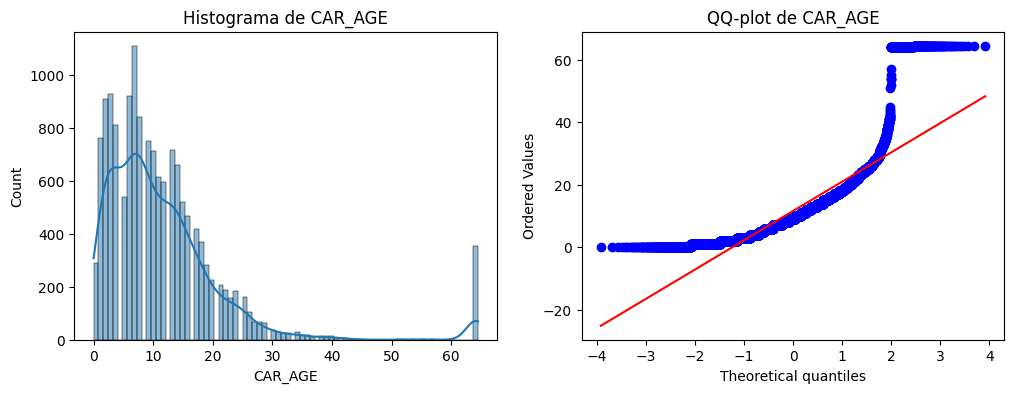

Variable: REACTIVE_SCORING
  Skewness: -0.12
  Kurtosis: 2.10


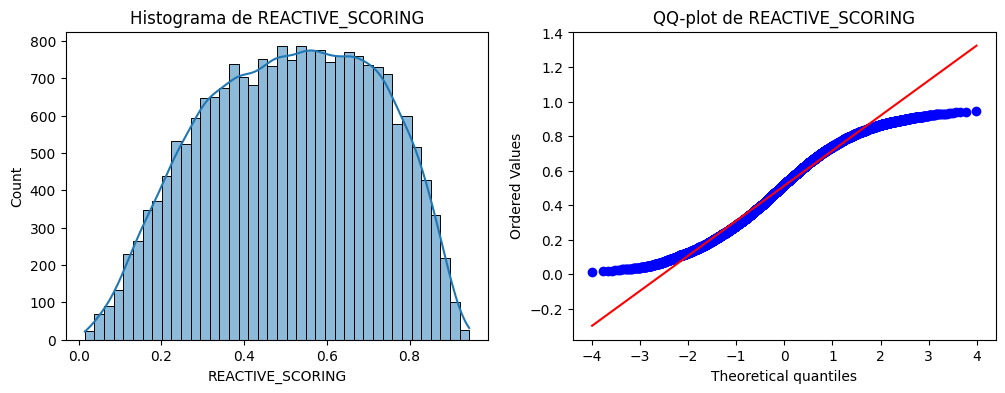

Variable: BEHAVIORAL_SCORING
  Skewness: -0.37
  Kurtosis: 2.31


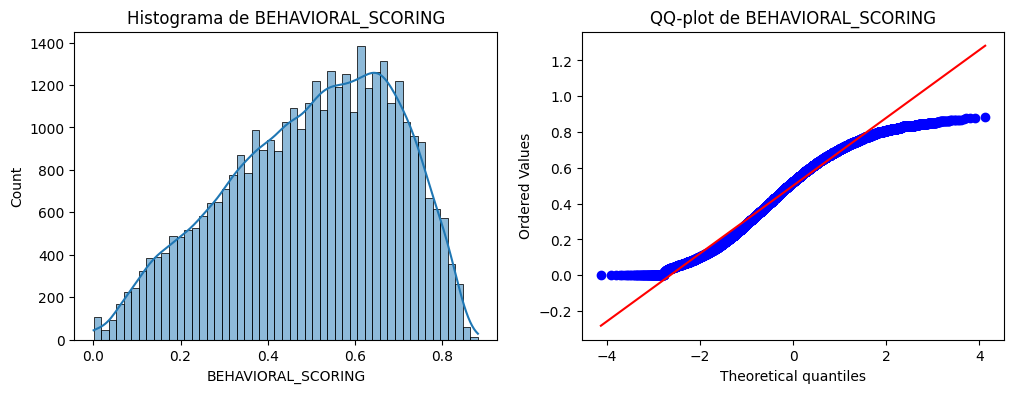

Variable: JOB_SENIORITY
  Skewness: 1.85
  Kurtosis: 7.14


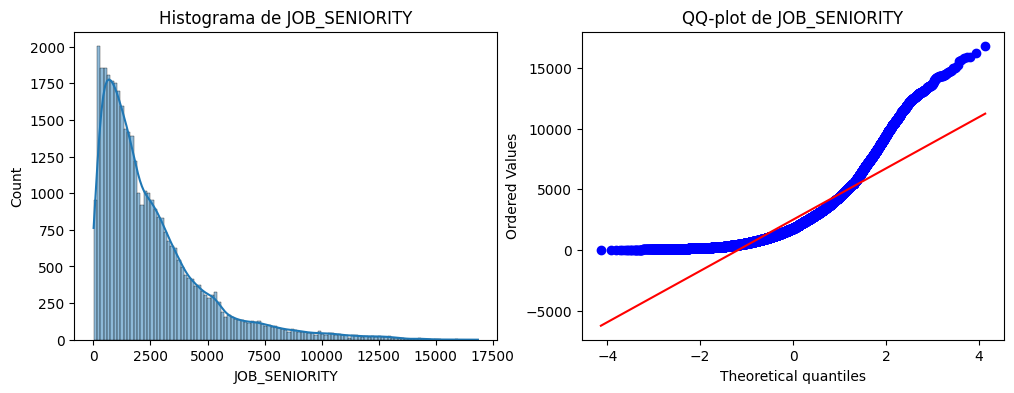

Variable: NUMBER_OF_PRODUCTS
  Skewness: 0.96
  Kurtosis: 4.44


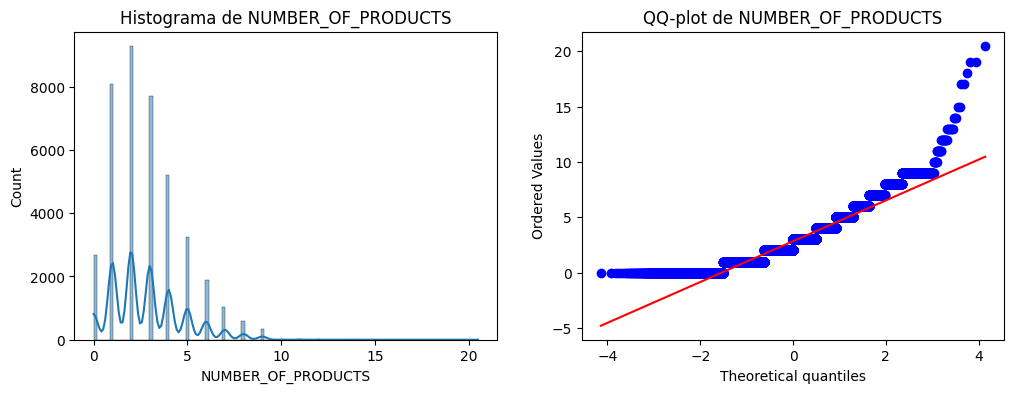

Variable: ATM_DRAWINGS_RATIO
  Skewness: 5.37
  Kurtosis: 94.05


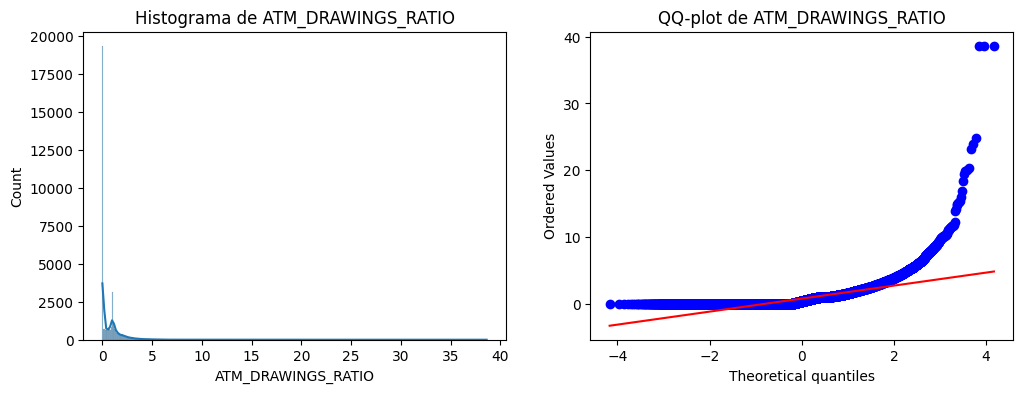

Variable: DRAWINGS_RATIO
  Skewness: 4.69
  Kurtosis: 62.04


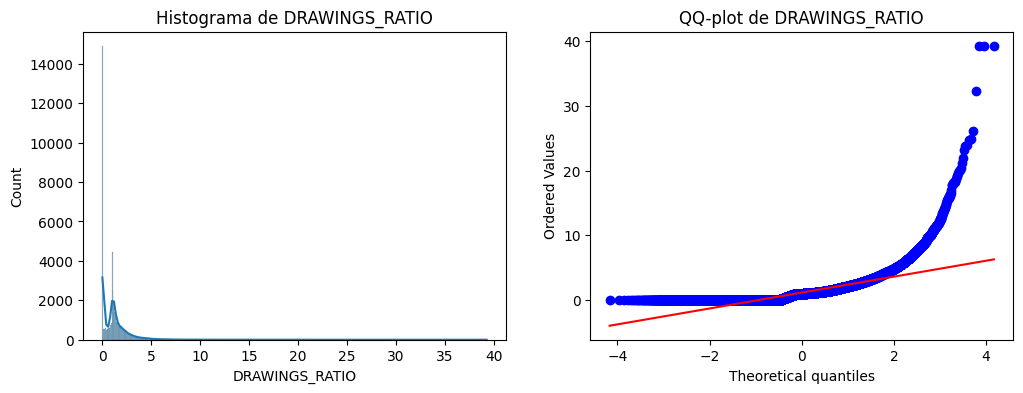

Variable: LOAN_CREDIT_GRANTED_SUM
  Skewness: 4.22
  Kurtosis: 37.40


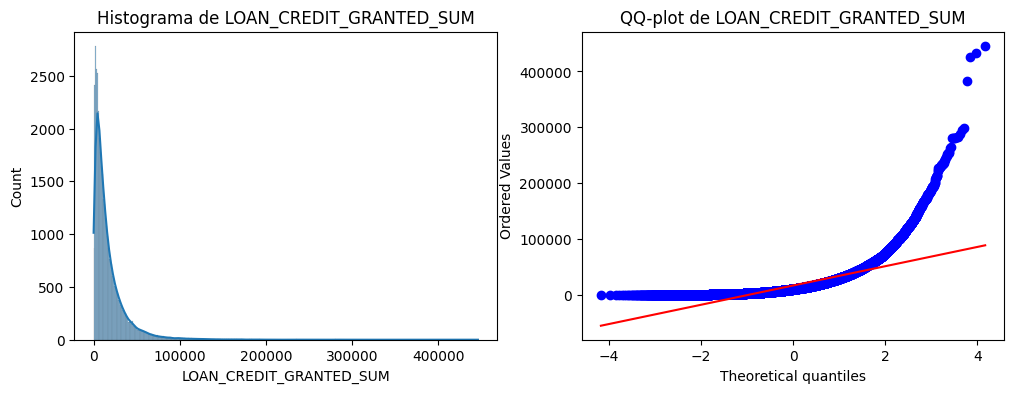

Variable: NUM_FLAG_INSURED
  Skewness: 1.67
  Kurtosis: 7.59


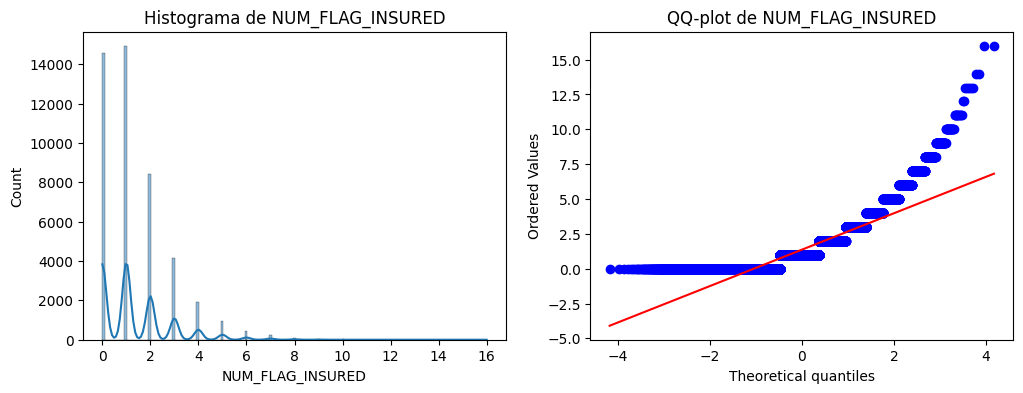

Variable: NUM_STATUS_NOT_USED
  Skewness: 6.16
  Kurtosis: 77.74


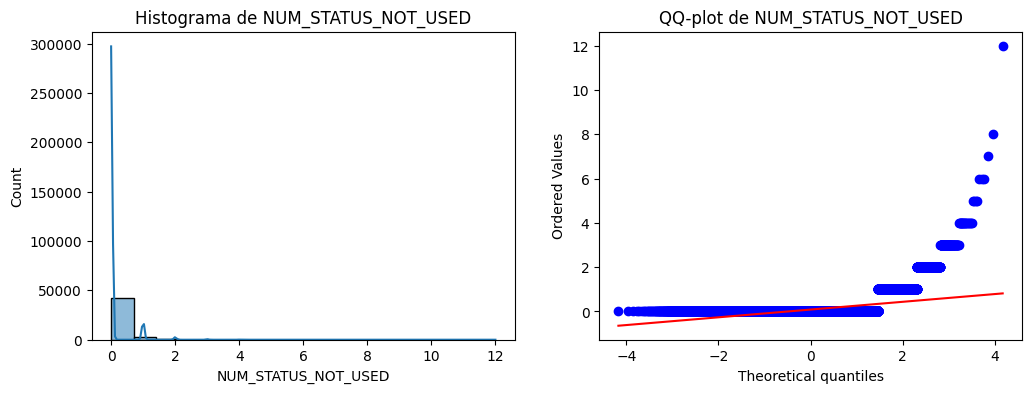

Variable: NUM_STATUS_DENIED
  Skewness: 4.15
  Kurtosis: 39.41


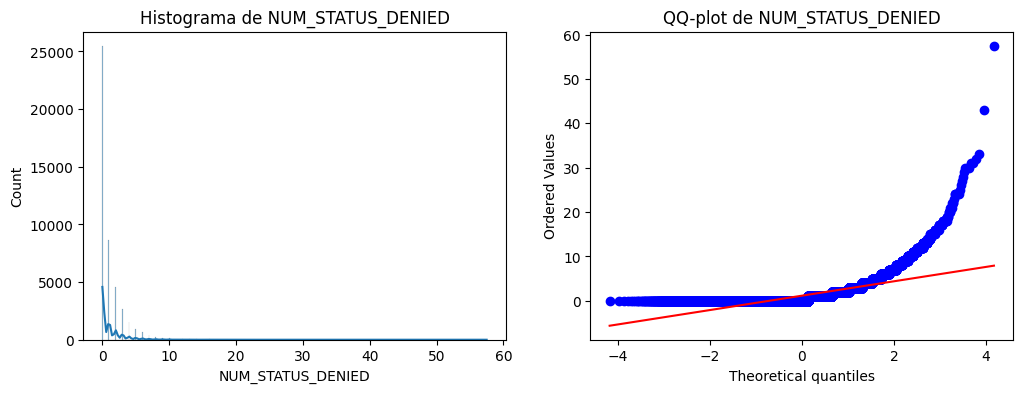

Variable: NUM_STATUS_AUTHORIZED
  Skewness: 1.29
  Kurtosis: 5.88


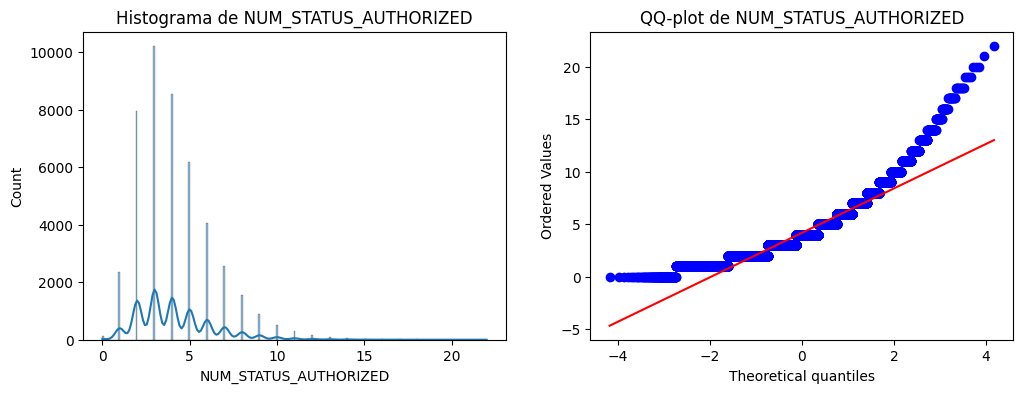

Variable: NUM_STATUS_ANNULLED
  Skewness: 3.46
  Kurtosis: 34.68


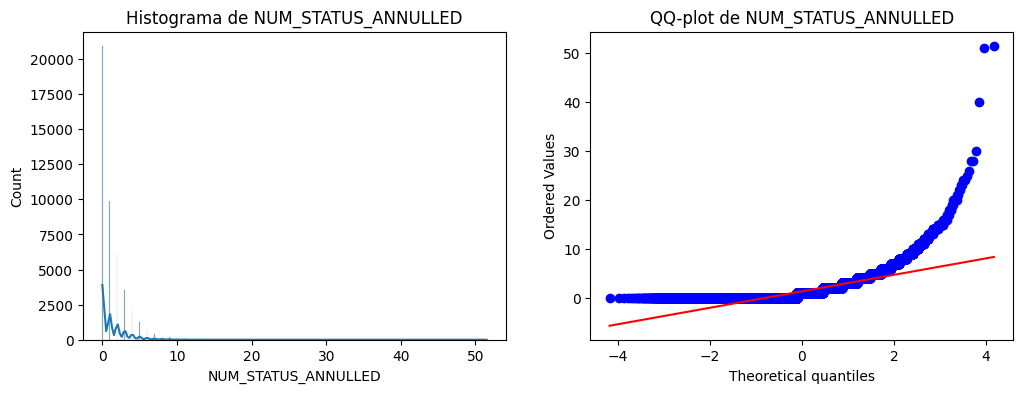

Variable: LOAN_VARIABLE_RATE_MIN
  Skewness: 20.45
  Kurtosis: 554.28


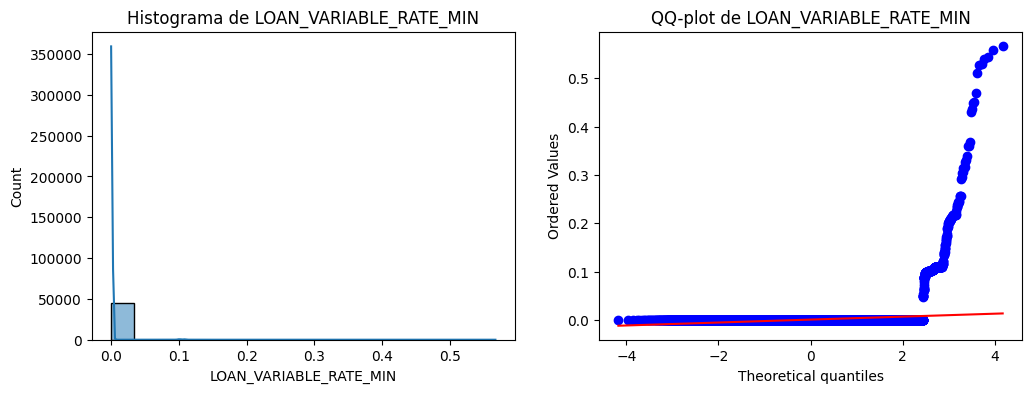

Variable: LOAN_VARIABLE_RATE_MAX
  Skewness: 1.59
  Kurtosis: 6.14


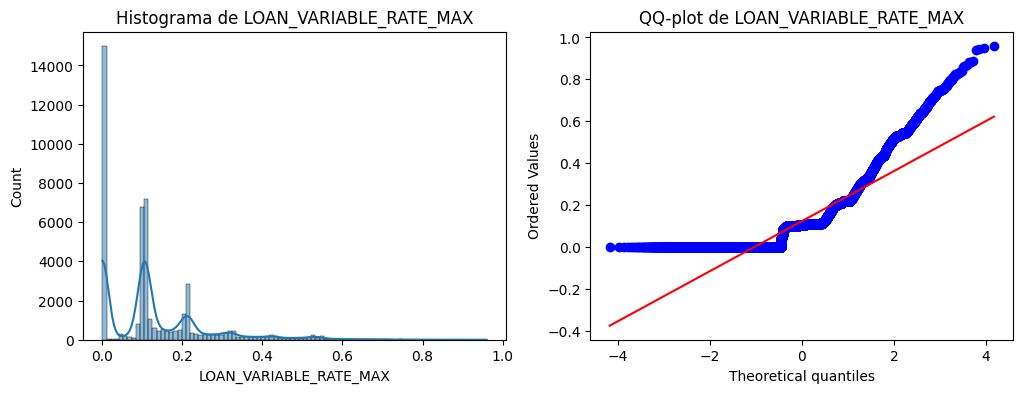

Variable: LOAN_APPLICATION_AMOUNT_MIN
  Skewness: 13.02
  Kurtosis: 292.65


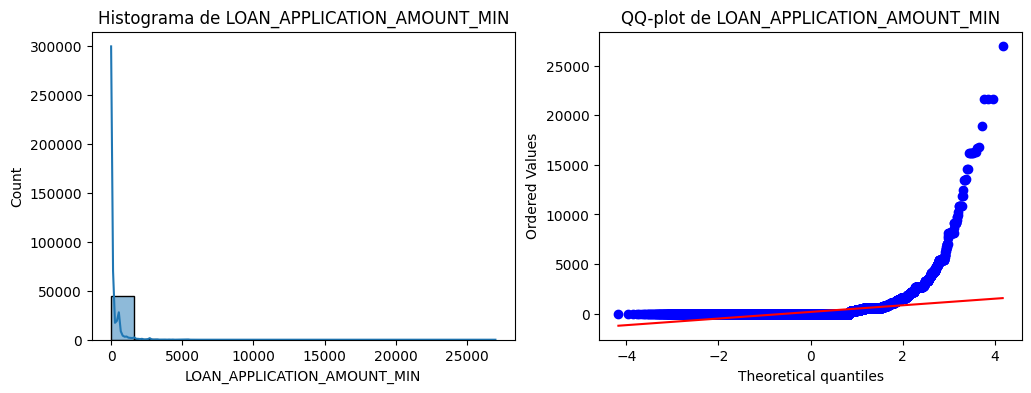

Variable: LOAN_CREDIT_GRANTED_MIN
  Skewness: 9.61
  Kurtosis: 187.35


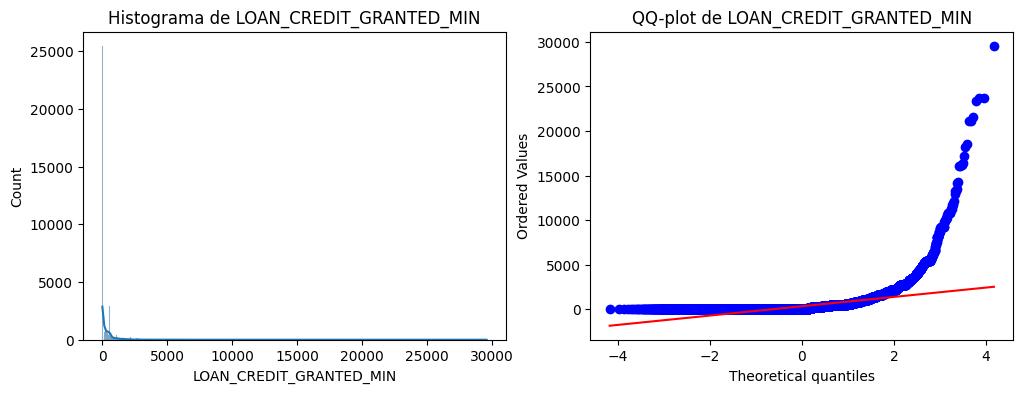

Variable: LOAN_CREDIT_GRANTED_MAX
  Skewness: 1.55
  Kurtosis: 6.23


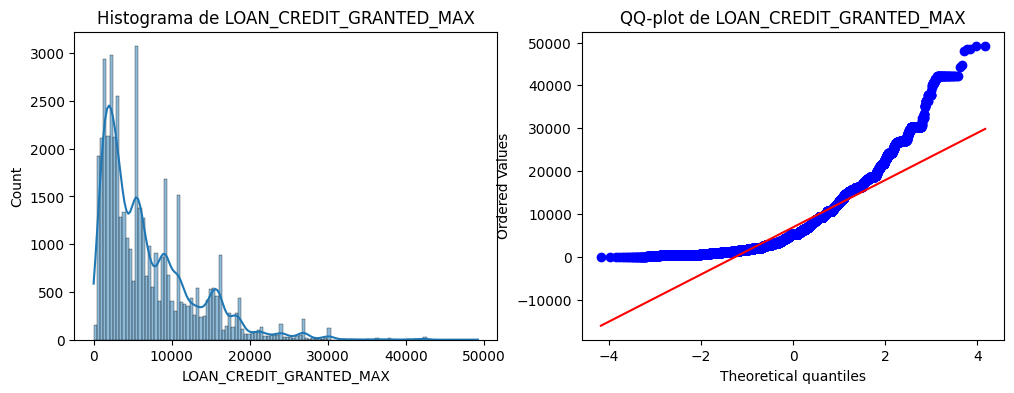

Variable: LOAN_APPLICATION_AMOUNT_SUM
  Skewness: 4.45
  Kurtosis: 42.13


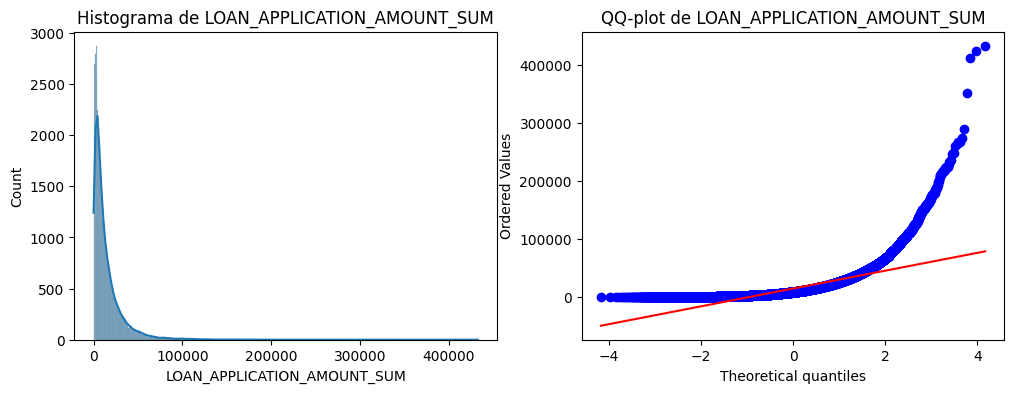

Variable: LOAN_APPLICATION_AMOUNT_MAX
  Skewness: 1.61
  Kurtosis: 6.34


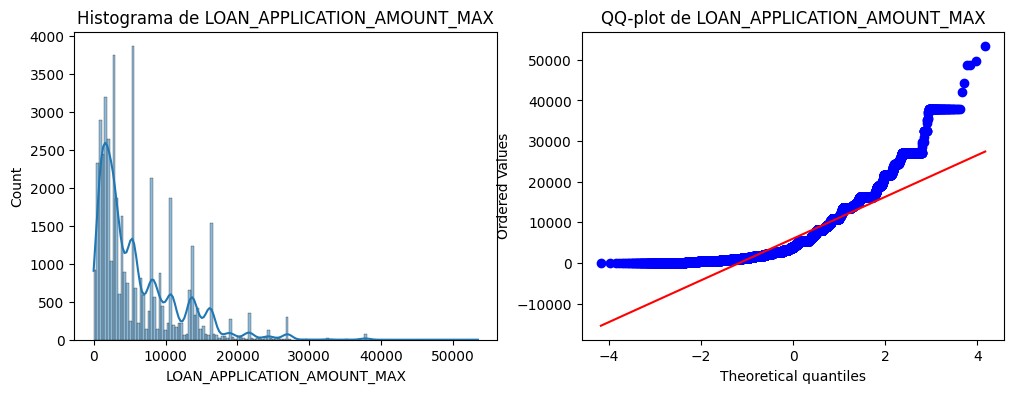

Variable: LOAN_ANNUITY_PAYMENT_SUM
  Skewness: 3.14
  Kurtosis: 21.37


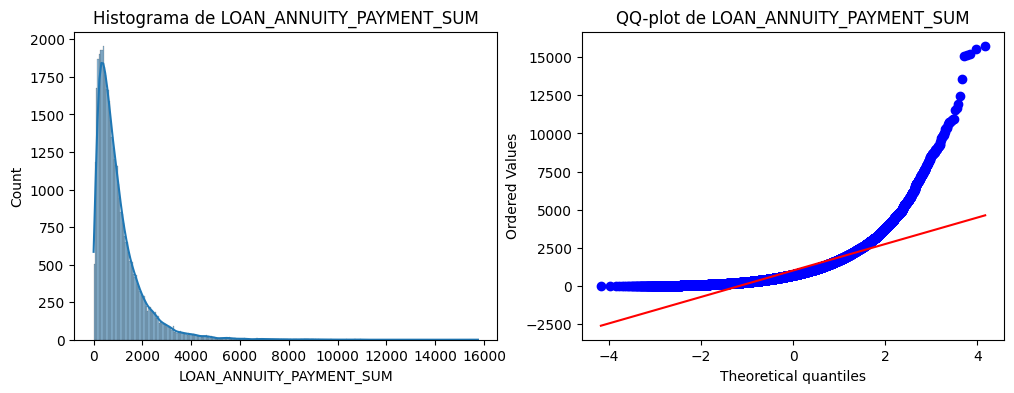

Variable: LOAN_ANNUITY_PAYMENT_MIN
  Skewness: 4.80
  Kurtosis: 52.67


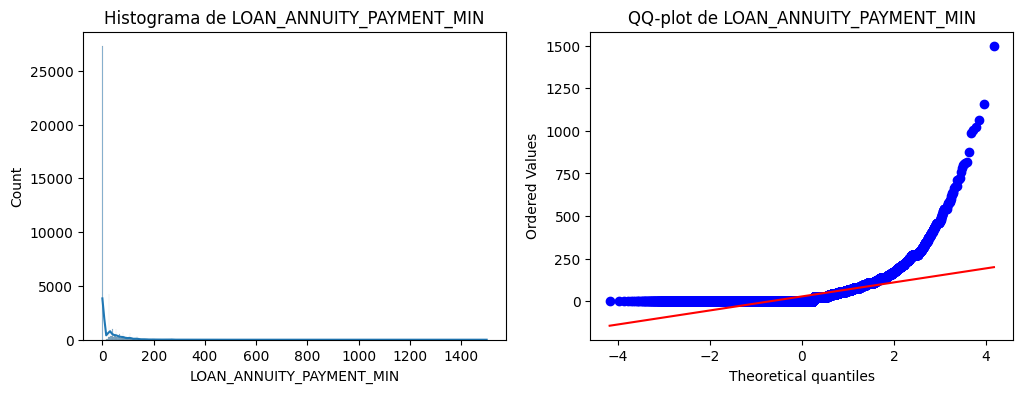

Variable: LOAN_ANNUITY_PAYMENT_MAX
  Skewness: 2.02
  Kurtosis: 13.75


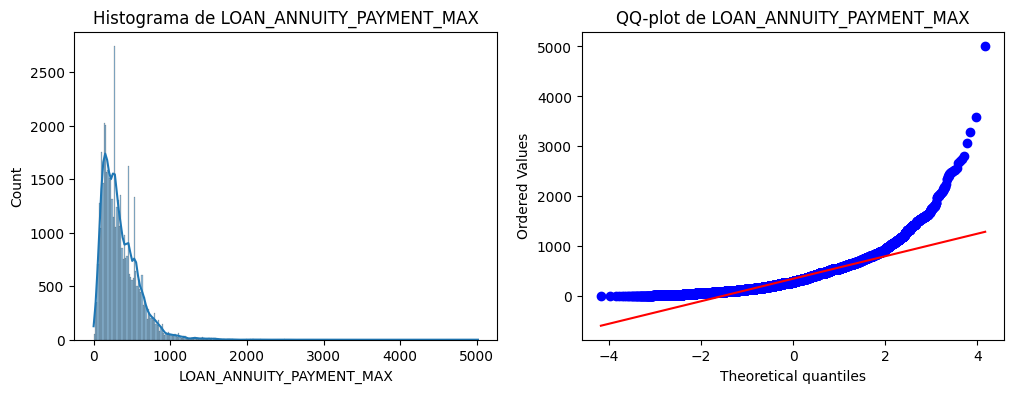

Variable: NUM_PREVIOUS_LOAN_APP
  Skewness: 2.13
  Kurtosis: 12.48


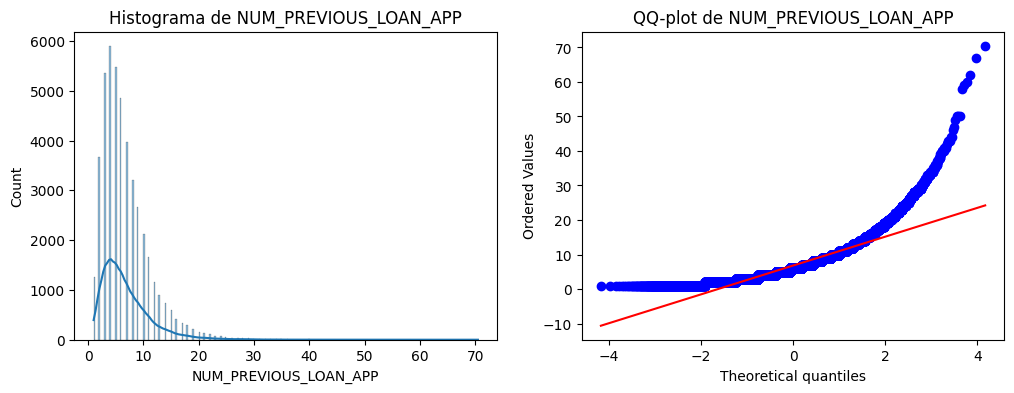

Variable: PROACTIVE_SCORING
  Skewness: -0.82
  Kurtosis: 2.79


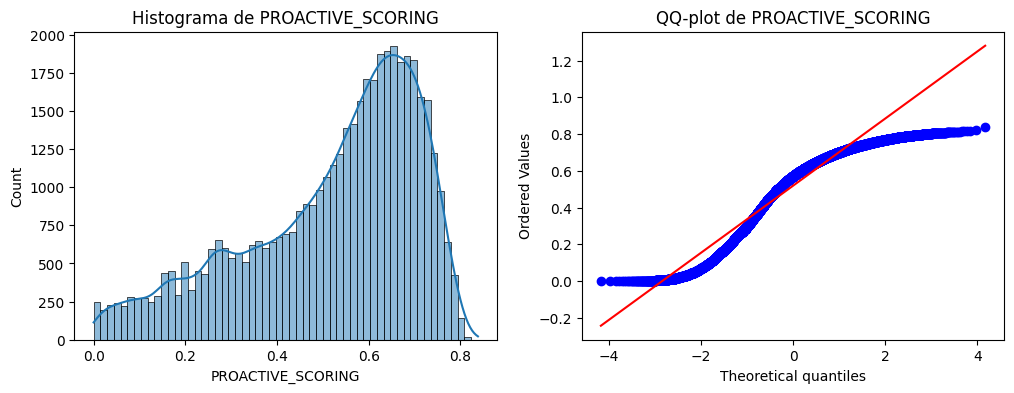

Variable: INSTALLMENT
  Skewness: 1.31
  Kurtosis: 7.54


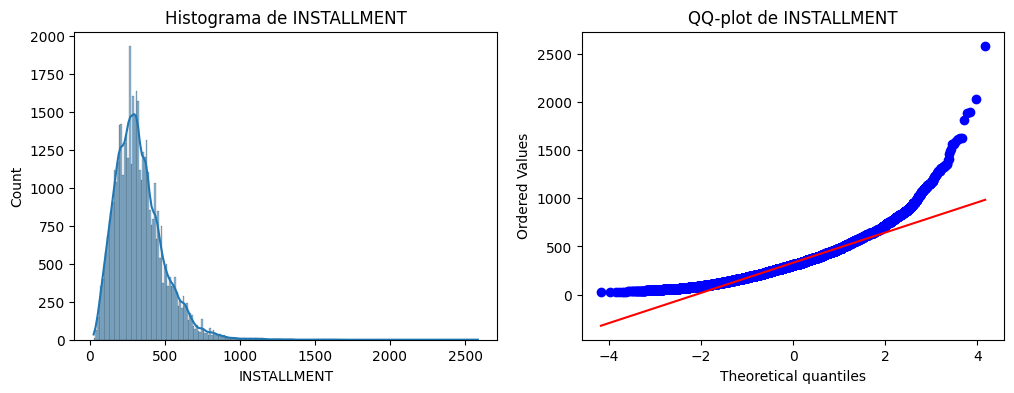

In [34]:
for col in num_vars_with_nan:
    print(f'Variable: {col}')
    data = df[col].dropna()
    
    # Skewness y kurtosis
    skewness = data.skew()
    kurtosis = data.kurtosis() + 3  # kurtosis en pandas es exceso, sumamos 3 para kurtosis total
    print(f'  Skewness: {skewness:.2f}')
    print(f'  Kurtosis: {kurtosis:.2f}')
    
    # Histograma + KDE
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(data, kde=True)
    plt.title(f'Histograma de {col}')
    
    # QQ-plot
    plt.subplot(1,2,2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'QQ-plot de {col}')
    
    plt.show()

**Conclusiones:**
1. **CAR_AGE no es normal**: Sesgada a la derecha y cola pesada
2. **BEHAVIORAL_SCORING:** Sesgo leve a la izquiera muy simetrica, cola ligeramente menos pesada a normal
3. **JOB_SENIORITY**: Sesgada a la derecha y cola muy pesada
4. **NUMBER_OF_PRODUCTS:** Sesgo moderado
5. **DRAWINGS_RATIO** No es normal, muy asimetrica
6. **ATM_DRAWINGS_RATIO** No es normal, muy asimetrica
7. **LOAN_APPLICATION_AMOUNT_MAX:** No es normal (Sesgada a la derecha y colas pesadas)
8. **LOAN_CREDIT_GRANTED_MIN:** Distribución muy extrema y con muchos outliers
9. **NUM_STATUS_NOT_USED:** Distribución muy extrema y con muchos outliers
10. **NUM_STATUS_DENIED:** Distribución muy asimetrica
11. **NUM_STATUS_AUTHORIZED:** Se hacerca a la normal
12. **NUM_STATUS_ANNULLED:** Esta variable presenta una distribución muy asimétrica y con cola larga,
13. **LOAN_VARIABLE_RATE_MIN:** Muy lejos de ser normal
14. **LOAN_VARIABLE_RATE_MAX:** Tiene algo de asimetria
15. **NUM_FLAG_INSURED:** No es normal del todo, pero presenta asimetria
16. **LOAN_CREDIT_GRANTED_MAX:** No es una distribución normal, tiene sesgo positivo y cierta concentración de outliers
17. **LOAN_CREDIT_GRANTED_SUM** Un sesgo tan alto y una curtosis tan elevada indican una distribución altamente asimétrica
18. **LOAN_APPLICATION_AMOUNT_SUM:** Distribución claramente no normal, con muchos valores atípicos y asimetría fuerte
19. **LOAN_APPLICATION_AMOUNT_MIN:** Distribución muy lejos de la normalidad, con muchos outliers y asimetría muy fuerte
20. **LOAN_ANNUITY_PAYMENT_SUM:** No es normal, hay asimetría a la derecha y outliers notables
21. **LOAN_ANNUITY_PAYMENT_MIN:** Fuertemente sesgada a la derecha
22. **LOAN_ANNUITY_PAYMENT_MAX:** No sigue una distribución normal, está sesgada a la derecha con valores extremos
23. **NUM_PREVIOUS_LOAN_APP:** Distribución no normal, sesgada a la derecha con outliers importantes
24. **PROACTIVE_SCORING:** Distribución algo asimétrica hacia la izquierda, pero razonablemente cercana a una distribución normal.
25. **INSTALLMENT:** Distribución asimétrica positiva y con colas pesadas, no es normal.

**Eliminamos variables con altos niveles de NaN**

In [35]:
df = df.drop(columns=['CAR_AGE'])

**Imputar variables numericas normal/no-normal**

In [36]:
# Copia del dataframe original
df_imputed = df.copy()

In [37]:
#Impute con la media si se considera aproximadamente normal (|skew| < 0.5)

normal_vars = [
    "NUM_STATUS_AUTHORIZED"
]

In [38]:
non_normal_vars = [
    "JOB_SENIORITY",
    "NUMBER_OF_PRODUCTS",
    "DRAWINGS_RATIO",
    "ATM_DRAWINGS_RATIO",
    "LOAN_APPLICATION_AMOUNT_MAX",
    "LOAN_CREDIT_GRANTED_MIN",
    "NUM_STATUS_NOT_USED",
    "NUM_STATUS_DENIED",
    "LOAN_VARIABLE_RATE_MIN",
    "LOAN_VARIABLE_RATE_MAX",
    "NUM_FLAG_INSURED",
    "LOAN_CREDIT_GRANTED_MAX",
    "LOAN_APPLICATION_AMOUNT_SUM",
    "LOAN_APPLICATION_AMOUNT_MIN",
    "LOAN_ANNUITY_PAYMENT_SUM",
    "LOAN_ANNUITY_PAYMENT_MAX",
    "NUM_PREVIOUS_LOAN_APP",
    "LOAN_ANNUITY_PAYMENT_MIN",
    "INSTALLMENT",
    "LOAN_CREDIT_GRANTED_SUM",
    "NUM_STATUS_ANNULLED"
]

In [39]:
#Imputar con medias

imputer_mean = SimpleImputer(strategy='mean')
df_imputed[normal_vars] = imputer_mean.fit_transform(df_imputed[normal_vars])

# Nombre del archivo
filename = f'SimpleImputer.pkl'
# Ruta completa
filepath = os.path.join(output_data, filename)
# Guarda el modelo final en un archivo
joblib.dump(imputer_mean, filepath)

['C:\\wokspace_github\\Data\\output_data\\SimpleImputer.pkl']

In [40]:
#Impute con la media si se considera aproximadamente normal (|skew| >= 0.5)

if non_normal_vars:
    imputer = KNNImputer(n_neighbors=5)
    df_knn = df_imputed[non_normal_vars]
    df_knn_imputed = imputer.fit_transform(df_knn)
    df_imputed[non_normal_vars] = pd.DataFrame(df_knn_imputed, columns=non_normal_vars, index=df_imputed.index)

    # Nombre del archivo
    filename = f'KNNImputer.pkl'
    # Ruta completa
    filepath = os.path.join(output_data, filename)
    # Guarda el modelo final en un archivo
    joblib.dump(imputer, filepath)

In [41]:
cat_vars_with_nan = ['EDUCATION', 'EMPLOYER_ORGANIZATION_TYPE']

for col in cat_vars_with_nan:
    print(f"\nFrecuencia para la variable '{col}':")
    freq_table = df_imputed[col].value_counts(dropna=False)
    percent_table = df_imputed[col].value_counts(normalize=True, dropna=False) * 100
    freq_df = pd.DataFrame({'Frecuencia': freq_table, 'Porcentaje': percent_table.round(2)})
    print(freq_df)


Frecuencia para la variable 'EDUCATION':
                       Frecuencia  Porcentaje
Secondary                   33885       73.59
NaN                         10327       22.43
Incomplete University        1342        2.91
Primary School                461        1.00
Master/PhD                     31        0.07

Frecuencia para la variable 'EMPLOYER_ORGANIZATION_TYPE':
       Frecuencia  Porcentaje
0001        10693       23.22
NaN          6733       14.62
0002         6436       13.98
0003         2538        5.51
0004         1803        3.92
0005         1597        3.47
0006         1498        3.25
0007         1325        2.88
0008         1218        2.65
0009         1118        2.43
0010         1087        2.36
0012          906        1.97
0014          852        1.85
0023          570        1.24
0022          515        1.12
0024          495        1.08
0016          493        1.07
0018          462        1.00
0025          452        0.98
0026          363      

In [42]:
# Para categóricas, imputar con "Unknown"
categorical_cols = ['EDUCATION', 'EMPLOYER_ORGANIZATION_TYPE']
for col in categorical_cols:
    df_imputed[col] = df_imputed[col].fillna('Unknown')

In [43]:
nan_percent = df_imputed.isna().mean() * 100
nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

# Mostramos el resultado
print(nan_percent)

REACTIVE_SCORING      54.250098
BEHAVIORAL_SCORING    18.815967
PROACTIVE_SCORING      0.023889
dtype: float64


In [44]:
categorical_features = df_imputed.select_dtypes(include=['object', 'category']).columns.tolist()

In [45]:
df_imputed.to_parquet(os.path.join(output_data,"credit_card_imputed.parquet"), index=False)

**Eliminamos variables key**

In [46]:
df_imputed = df_imputed.drop(columns='CLIENT_ID')

In [47]:
categorical_features = df_imputed.select_dtypes(include=['object', 'category']).columns.tolist()

**Observamos la cardinalidad de las variables str**

In [48]:
for col in categorical_features:
    print(f"Cardinalidad de '{col}':{df_imputed[col].nunique()}")

Cardinalidad de 'NAME_PRODUCT_TYPE':2
Cardinalidad de 'EDUCATION':5
Cardinalidad de 'MARITAL_STATUS':2
Cardinalidad de 'HOME_SITUATION':6
Cardinalidad de 'OWN_INSURANCE_CAR':2
Cardinalidad de 'OCCUPATION':5
Cardinalidad de 'HOME_OWNER':2
Cardinalidad de 'EMPLOYER_ORGANIZATION_TYPE':57
Cardinalidad de 'CURRENCY':1


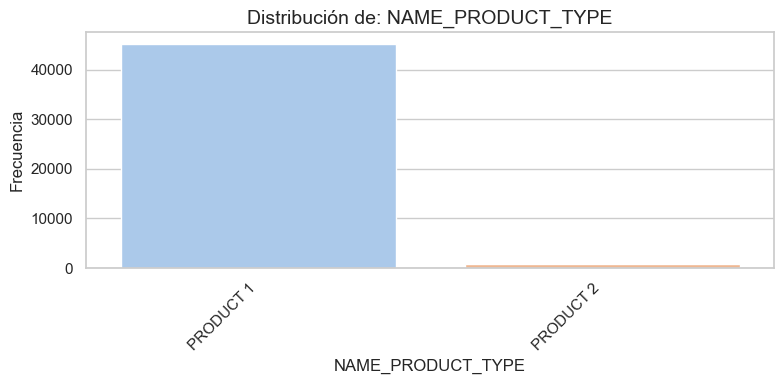

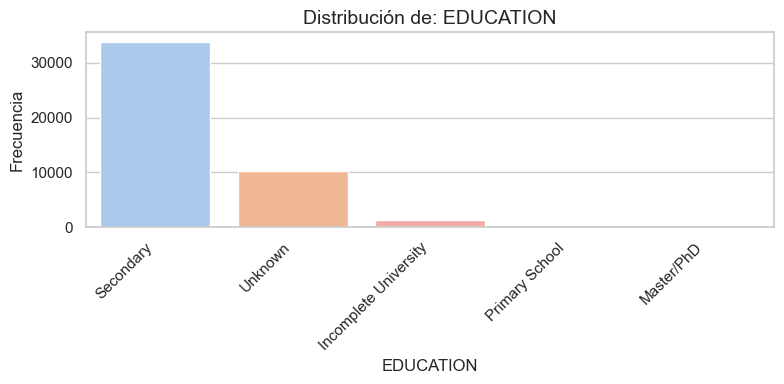

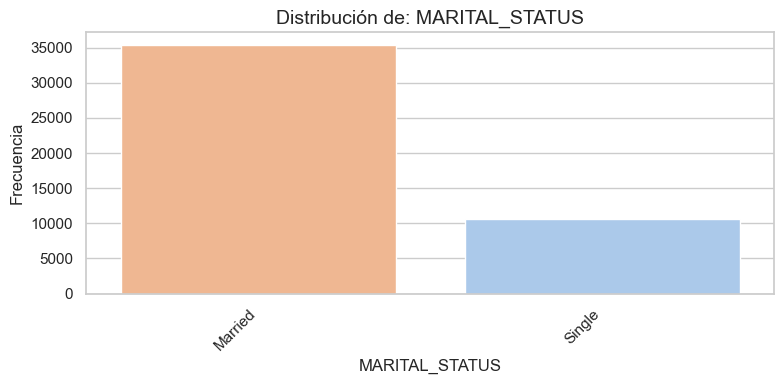

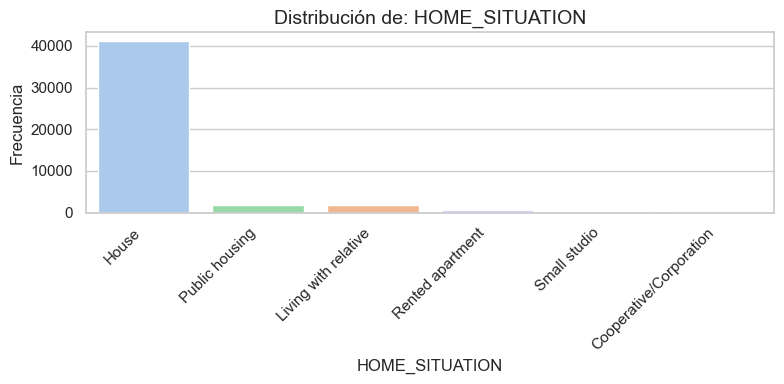

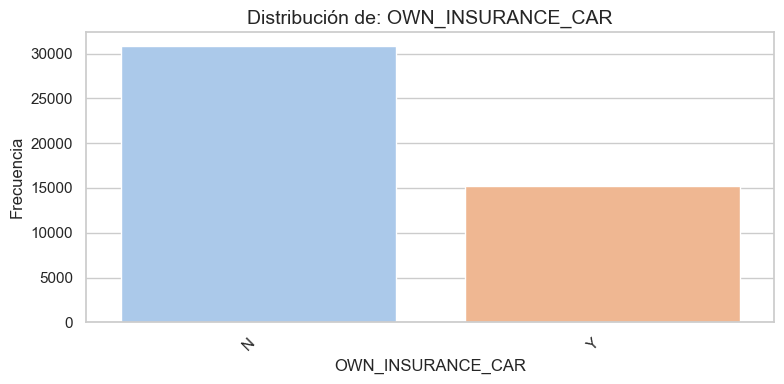

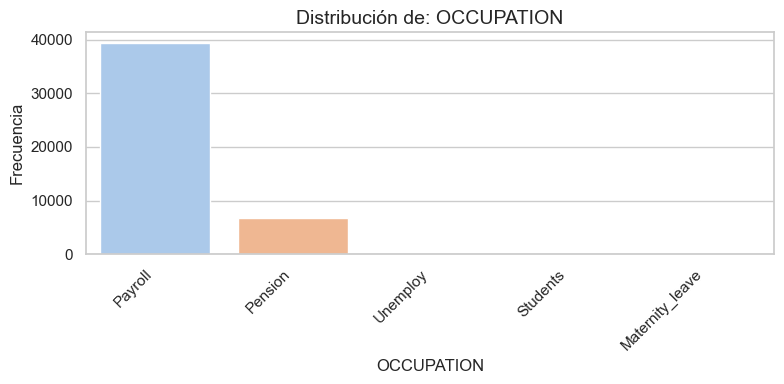

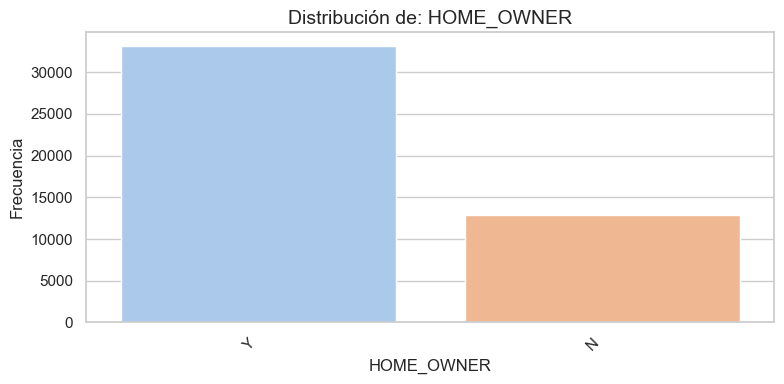

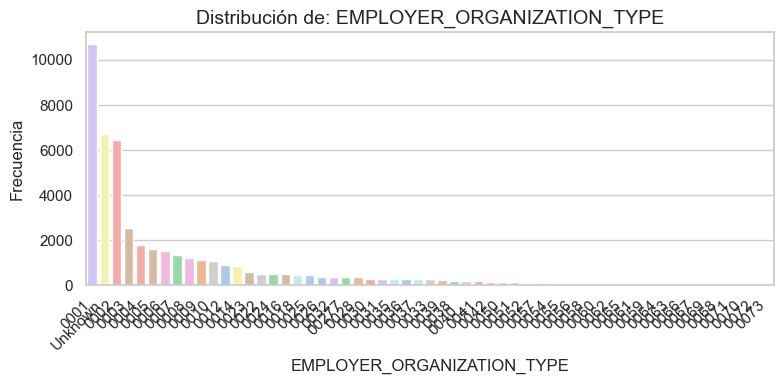

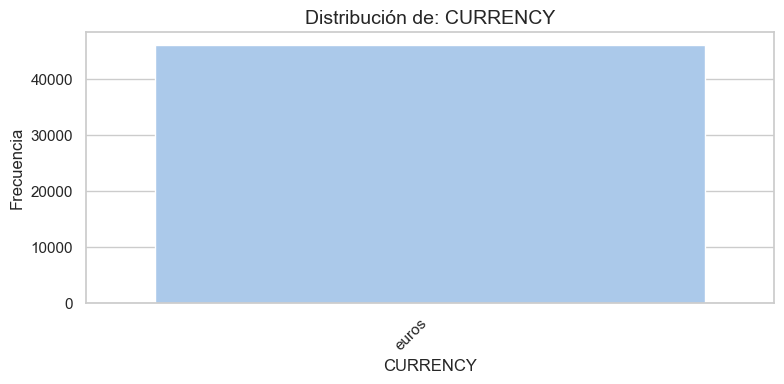

In [49]:
sns.set(style="whitegrid")

for col in categorical_features:
    plt.figure(figsize=(8, 4))
    order = df_imputed[col].value_counts().index
    sns.countplot(data=df_imputed, x=col, hue=col, order=order, palette="pastel", legend=False)
    plt.title(f'Distribución de: {col}', fontsize=14)
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

**Eliminamos la variable currency pues tiene un solo nivel**

In [50]:
df_imputed = df_imputed.drop(columns='CURRENCY')

**Frequency encoding**

In [51]:
#Tenemos alta cardinalidad en EMPLOYER_ORGANIZATION_TYPE, podemos usar para ello ademas que es bueno para modelos arboles

freq_map = df_imputed['EMPLOYER_ORGANIZATION_TYPE'].value_counts()
df_imputed['EMPLOYER_ORGANIZATION_FREQ'] = df_imputed['EMPLOYER_ORGANIZATION_TYPE'].map(freq_map)

In [52]:
# Nombre del archivo
filename = f'freq_map_employer_org_type.pkl'

# Ruta completa
filepath = os.path.join(output_data, filename)

joblib.dump(freq_map, filepath)

['C:\\wokspace_github\\Data\\output_data\\freq_map_employer_org_type.pkl']

In [53]:
df_imputed = df_imputed.drop(columns='EMPLOYER_ORGANIZATION_TYPE')

**ONE Hot encoder**

In [54]:
# Seleccionamos las variables categóricas
cat_cols = df_imputed.select_dtypes(include=['object', 'category']).columns.tolist()

In [55]:
# Aplicamos OneHotEncoding
df_encoded = pd.get_dummies(df_imputed, columns=cat_cols, drop_first=True)

In [56]:
df_encoded.to_parquet(os.path.join(output_data,"credit_card_encoded.parquet"), index=False)

**Relacion de las variables exogenas y scores de riesgo**

In [57]:
numerical_cols = df_imputed.select_dtypes(include=['float64', 'int64']).columns

In [58]:
cols_to_remove = ['REACTIVE_SCORING','PROACTIVE_SCORING','BEHAVIORAL_SCORING','NON_COMPLIANT_CONTRACT']

numerical_cols = [col for col in numerical_cols if col not in cols_to_remove]

- REACTIVE_SCORING

In [59]:
df_known        = df_encoded[df_encoded['REACTIVE_SCORING'].notna()]
df_missing      = df_encoded[df_encoded['REACTIVE_SCORING'].isna()]

In [60]:
X = df_known.drop(columns=['REACTIVE_SCORING','PROACTIVE_SCORING','BEHAVIORAL_SCORING','NON_COMPLIANT_CONTRACT'], axis=1)
y = df_known['REACTIVE_SCORING']

In [61]:
for feature in numerical_cols:
    pearson_corr, _ = pearsonr(X[feature], y)
    spearman_corr, _ = spearmanr(X[feature], y)

    print(f"{feature:25} → Pearson: {pearson_corr: .3f} | Spearman: {spearman_corr: .3f}", end=' ')

    if abs(pearson_corr) < abs(spearman_corr) - 0.1:
        print("Posible relación NO lineal")
    elif abs(pearson_corr) >= 0.5:
        print("Relación lineal fuerte")
    else:
        print("Relación débil o ambigua")

TOTAL_INCOME              → Pearson:  0.092 | Spearman:  0.089 Relación débil o ambigua
AMOUNT_PRODUCT            → Pearson:  0.171 | Spearman:  0.168 Relación débil o ambigua
INSTALLMENT               → Pearson:  0.111 | Spearman:  0.107 Relación débil o ambigua
REGION_SCORE              → Pearson:  0.116 | Spearman:  0.100 Relación débil o ambigua
AGE_IN_YEARS              → Pearson:  0.569 | Spearman:  0.570 Relación lineal fuerte
JOB_SENIORITY             → Pearson:  0.245 | Spearman:  0.247 Relación débil o ambigua
HOME_SENIORITY            → Pearson:  0.171 | Spearman:  0.154 Relación débil o ambigua
LAST_UPDATE               → Pearson:  0.055 | Spearman:  0.056 Relación débil o ambigua
FAMILY_SIZE               → Pearson: -0.117 | Spearman: -0.123 Relación débil o ambigua
DAYS_LAST_INFO_CHANGE     → Pearson:  0.160 | Spearman:  0.157 Relación débil o ambigua
NUMBER_OF_PRODUCTS        → Pearson: -0.016 | Spearman: -0.009 Relación débil o ambigua
DIGITAL_CLIENT            → Pearso

- PROACTIVE_SCORING

In [62]:
df_known        = df_encoded[df_encoded['PROACTIVE_SCORING'].notna()]
df_missing      = df_encoded[df_encoded['PROACTIVE_SCORING'].isna()]

In [63]:
X = df_known.drop(columns=['REACTIVE_SCORING','PROACTIVE_SCORING','BEHAVIORAL_SCORING','NON_COMPLIANT_CONTRACT'], axis=1)
y = df_known['PROACTIVE_SCORING']

In [64]:
for feature in numerical_cols:
    pearson_corr, _ = pearsonr(X[feature], y)
    spearman_corr, _ = spearmanr(X[feature], y)

    print(f"{feature:25} → Pearson: {pearson_corr: .3f} | Spearman: {spearman_corr: .3f}", end=' ')

    if abs(pearson_corr) < abs(spearman_corr) - 0.1:
        print("Posible relación NO lineal")
    elif abs(pearson_corr) >= 0.5:
        print("Relación lineal fuerte")
    else:
        print("Relación débil o ambigua")

TOTAL_INCOME              → Pearson:  0.150 | Spearman:  0.175 Relación débil o ambigua
AMOUNT_PRODUCT            → Pearson:  0.122 | Spearman:  0.121 Relación débil o ambigua
INSTALLMENT               → Pearson:  0.116 | Spearman:  0.117 Relación débil o ambigua
REGION_SCORE              → Pearson:  0.210 | Spearman:  0.204 Relación débil o ambigua
AGE_IN_YEARS              → Pearson:  0.095 | Spearman:  0.102 Relación débil o ambigua
JOB_SENIORITY             → Pearson:  0.071 | Spearman:  0.078 Relación débil o ambigua
HOME_SENIORITY            → Pearson:  0.059 | Spearman:  0.066 Relación débil o ambigua
LAST_UPDATE               → Pearson:  0.034 | Spearman:  0.034 Relación débil o ambigua
FAMILY_SIZE               → Pearson: -0.021 | Spearman: -0.018 Relación débil o ambigua
DAYS_LAST_INFO_CHANGE     → Pearson:  0.235 | Spearman:  0.243 Relación débil o ambigua
NUMBER_OF_PRODUCTS        → Pearson: -0.012 | Spearman: -0.011 Relación débil o ambigua
DIGITAL_CLIENT            → Pear

- BEHAVIORAL_SCORING

In [65]:
df_known        = df_encoded[df_encoded['BEHAVIORAL_SCORING'].notna()]
df_missing      = df_encoded[df_encoded['BEHAVIORAL_SCORING'].isna()]

In [66]:
X = df_known.drop(columns=['REACTIVE_SCORING','PROACTIVE_SCORING','BEHAVIORAL_SCORING','NON_COMPLIANT_CONTRACT'], axis=1)
y = df_known['BEHAVIORAL_SCORING']

In [67]:
for feature in numerical_cols:
    pearson_corr, _ = pearsonr(X[feature], y)
    spearman_corr, _ = spearmanr(X[feature], y)

    print(f"{feature:25} → Pearson: {pearson_corr: .3f} | Spearman: {spearman_corr: .3f}", end=' ')

    if abs(pearson_corr) < abs(spearman_corr) - 0.1:
        print("Posible relación NO lineal")
    elif abs(pearson_corr) >= 0.5:
        print("Relación lineal fuerte")
    else:
        print("Relación débil o ambigua")

TOTAL_INCOME              → Pearson: -0.069 | Spearman: -0.081 Relación débil o ambigua
AMOUNT_PRODUCT            → Pearson:  0.039 | Spearman:  0.028 Relación débil o ambigua
INSTALLMENT               → Pearson:  0.019 | Spearman:  0.006 Relación débil o ambigua
REGION_SCORE              → Pearson:  0.003 | Spearman:  0.007 Relación débil o ambigua
AGE_IN_YEARS              → Pearson:  0.164 | Spearman:  0.161 Relación débil o ambigua
JOB_SENIORITY             → Pearson:  0.106 | Spearman:  0.120 Relación débil o ambigua
HOME_SENIORITY            → Pearson:  0.094 | Spearman:  0.092 Relación débil o ambigua
LAST_UPDATE               → Pearson:  0.098 | Spearman:  0.098 Relación débil o ambigua
FAMILY_SIZE               → Pearson: -0.039 | Spearman: -0.036 Relación débil o ambigua
DAYS_LAST_INFO_CHANGE     → Pearson:  0.083 | Spearman:  0.072 Relación débil o ambigua
NUMBER_OF_PRODUCTS        → Pearson: -0.072 | Spearman: -0.066 Relación débil o ambigua
DIGITAL_CLIENT            → Pear

**5. Predicción de scores**

In [68]:
df_scores = df_encoded.copy()

In [69]:
df_scores.head()

,NON_COMPLIANT_CONTRACT,TOTAL_INCOME,AMOUNT_PRODUCT,INSTALLMENT,REGION_SCORE,AGE_IN_YEARS,JOB_SENIORITY,HOME_SENIORITY,LAST_UPDATE,FAMILY_SIZE,...,HOME_SITUATION_Living with relative,HOME_SITUATION_Public housing,HOME_SITUATION_Rented apartment,HOME_SITUATION_Small studio,OWN_INSURANCE_CAR_Y,OCCUPATION_Payroll,OCCUPATION_Pension,OCCUPATION_Students,OCCUPATION_Unemploy,HOME_OWNER_Y
0,0,1350.0,3234.60,298.24,0.005084,34.320548,390.0,6610.0,4362.0,1.0,...,0,0,0,0,0,1,0,0,0,1
1,0,1620.0,4890.24,386.37,0.046220,40.652055,1681.0,56.0,4992.0,1.0,...,0,0,0,0,0,1,0,0,0,0
2,0,2430.0,5004.29,242.30,0.059364,61.331507,597.0,8937.0,5764.0,2.0,...,0,0,0,0,0,1,0,0,0,1
3,0,1080.0,15522.03,455.38,0.022625,40.219178,1106.0,7950.0,4683.0,4.0,...,0,0,0,0,0,1,0,0,0,1
4,1,2430.0,11634.95,619.87,0.001276,46.410959,4640.0,8958.0,475.0,2.0,...,0,0,0,0,0,1,0,0,0,1


In [70]:
df_scores.shape

(46046, 77)

In [71]:
df_exogenas = df_scores.drop(columns=['NON_COMPLIANT_CONTRACT','REACTIVE_SCORING','PROACTIVE_SCORING','BEHAVIORAL_SCORING'])

- REACTIVE_SCORING

Dado que la distribución de la variable BEHAVIORAL_SCORING presenta una asimetría leve (Skewness = -0.37) y una curtosis próxima a la normal (Kurtosis = 2.31), se considera que los datos siguen aproximadamente una distribución normal sin colas pesadas. Por tanto, no se justifica la eliminación de valores atípicos, ya que no se observa evidencia significativa de extremos que puedan distorsionar el análisis.

In [72]:
df_reactive_known        = df_scores[df_scores['REACTIVE_SCORING'].notna()].copy()

In [73]:
X = df_reactive_known.drop(columns=['NON_COMPLIANT_CONTRACT','REACTIVE_SCORING','PROACTIVE_SCORING','BEHAVIORAL_SCORING'], axis=1)
y = df_reactive_known['REACTIVE_SCORING']

In [74]:
# Separar train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,       # Regularización L1
    reg_lambda=1,      # Regularización L2
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [76]:
# Nombre del archivo
filename = f'reactive_score.pkl'

# Ruta completa
filepath = os.path.join(output_data, filename)

# Guarda el modelo final en un archivo
joblib.dump(xgb_model, filepath)

['C:\\wokspace_github\\Data\\output_data\\reactive_score.pkl']

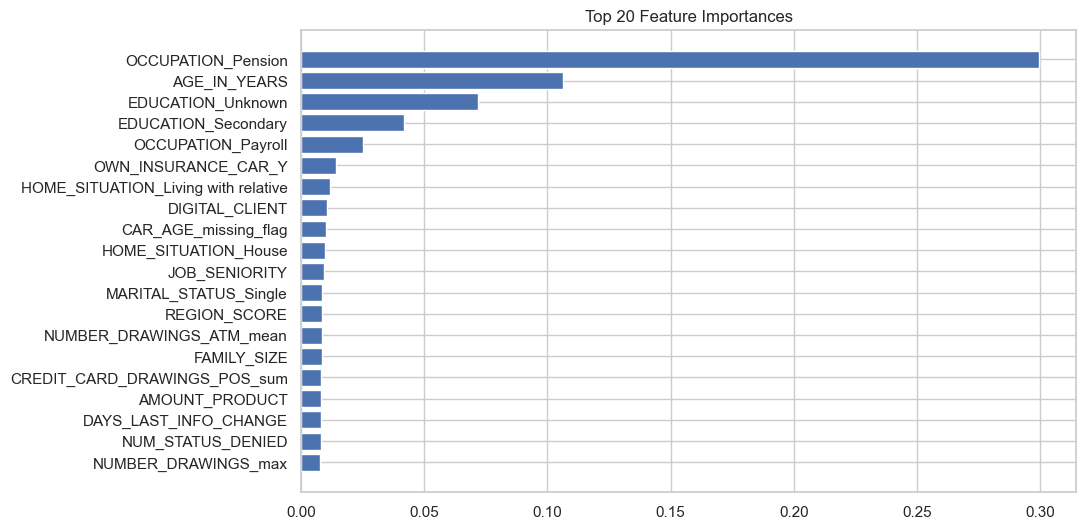

In [77]:
importances = xgb_model.feature_importances_
features = X_train.columns if hasattr(X_train, 'columns') else [f"f{i}" for i in range(X_train.shape[1])]
feat_imp_df = pd.DataFrame({"Feature": features, "Importance": importances})
feat_imp_df = feat_imp_df.sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df["Feature"][:20][::-1], feat_imp_df["Importance"][:20][::-1])
plt.title("Top 20 Feature Importances")
plt.show()

In [78]:
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [79]:
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test  MSE:", mean_squared_error(y_test, y_test_pred))
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test  R2:", r2_score(y_test, y_test_pred))

Train MSE: 0.006990804369054949
Test  MSE: 0.026192694797566814
Train R2: 0.8338382234296389
Test  R2: 0.37649603636423723


In [80]:
REACTIVE_SCORING_pred = xgb_model.predict(df_exogenas)

- PROACTIVE_SCORING

In [81]:
df_reactive_known        = df_scores[df_scores['PROACTIVE_SCORING'].notna()].copy()
df_reactive_known.shape

(46035, 77)

In [82]:
Q1 = df_reactive_known['PROACTIVE_SCORING'].quantile(0.25)
Q3 = df_reactive_known['PROACTIVE_SCORING'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [83]:
df_clean  = df_reactive_known[(df_reactive_known['PROACTIVE_SCORING'] >= lower_bound) & (df_reactive_known['PROACTIVE_SCORING'] <= upper_bound)].copy()
df_clean.shape

(46011, 77)

In [84]:
X = df_clean.drop(columns=['NON_COMPLIANT_CONTRACT','REACTIVE_SCORING','PROACTIVE_SCORING','BEHAVIORAL_SCORING'], axis=1)
y = df_clean['PROACTIVE_SCORING']

In [85]:
# Separar train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,       # Regularización L1
    reg_lambda=1,      # Regularización L2
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [87]:
# Nombre del archivo
filename = f'proactive_score.pkl'

# Ruta completa
filepath = os.path.join(output_data, filename)

# Guarda el modelo final en un archivo
joblib.dump(xgb_model, filepath)

['C:\\wokspace_github\\Data\\output_data\\proactive_score.pkl']

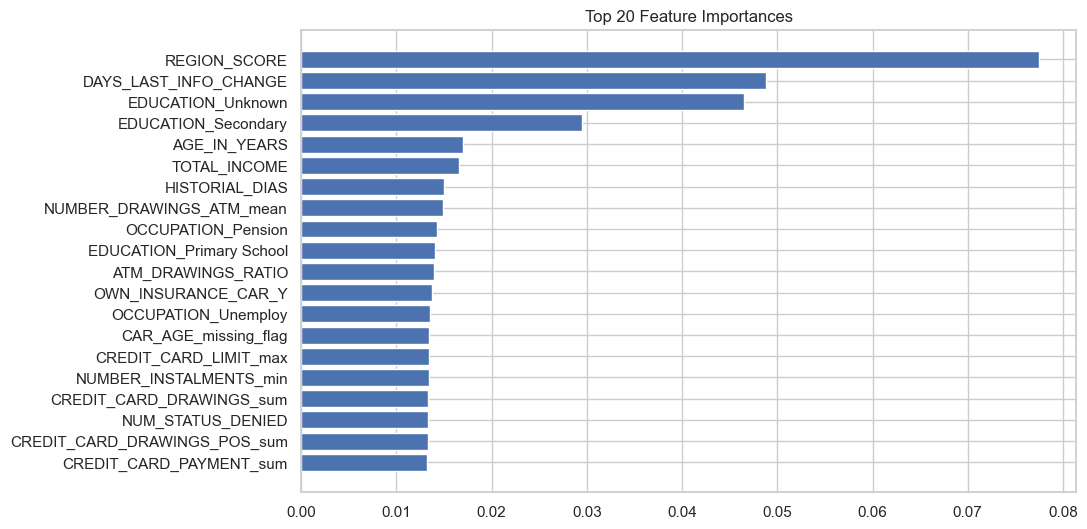

In [88]:
importances = xgb_model.feature_importances_
features = X_train.columns if hasattr(X_train, 'columns') else [f"f{i}" for i in range(X_train.shape[1])]
feat_imp_df = pd.DataFrame({"Feature": features, "Importance": importances})
feat_imp_df = feat_imp_df.sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df["Feature"][:20][::-1], feat_imp_df["Importance"][:20][::-1])
plt.title("Top 20 Feature Importances")
plt.show()

In [89]:
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [90]:
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test  MSE:", mean_squared_error(y_test, y_test_pred))
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test  R2:", r2_score(y_test, y_test_pred))

Train MSE: 0.011644415946321545
Test  MSE: 0.02741022980790412
Train R2: 0.675872579623839
Test  R2: 0.2385859638311112


In [91]:
PROACTIVE_SCORING_pred = xgb_model.predict(df_exogenas)

- BEHAVIORAL_SCORING

In [92]:
df_behavioral_known   = df_scores[df_scores['BEHAVIORAL_SCORING'].notna()]
df_reactive_known.shape

(46035, 77)

In [93]:
Q1 = df_reactive_known['BEHAVIORAL_SCORING'].quantile(0.25)
Q3 = df_reactive_known['BEHAVIORAL_SCORING'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [94]:
df_clean  = df_reactive_known[(df_reactive_known['BEHAVIORAL_SCORING'] >= lower_bound) & (df_reactive_known['BEHAVIORAL_SCORING'] <= upper_bound)].copy()
df_clean.shape

(37372, 77)

In [95]:
X = df_clean.drop(columns=['NON_COMPLIANT_CONTRACT','REACTIVE_SCORING','PROACTIVE_SCORING','BEHAVIORAL_SCORING'], axis=1)
y = df_clean['BEHAVIORAL_SCORING']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,       # Regularización L1
    reg_lambda=1,      # Regularización L2
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [98]:
# Nombre del archivo
filename = f'behavioral_score.pkl'

# Ruta completa
filepath = os.path.join(output_data, filename)

# Guarda el modelo final en un archivo
joblib.dump(xgb_model, filepath)

['C:\\wokspace_github\\Data\\output_data\\behavioral_score.pkl']

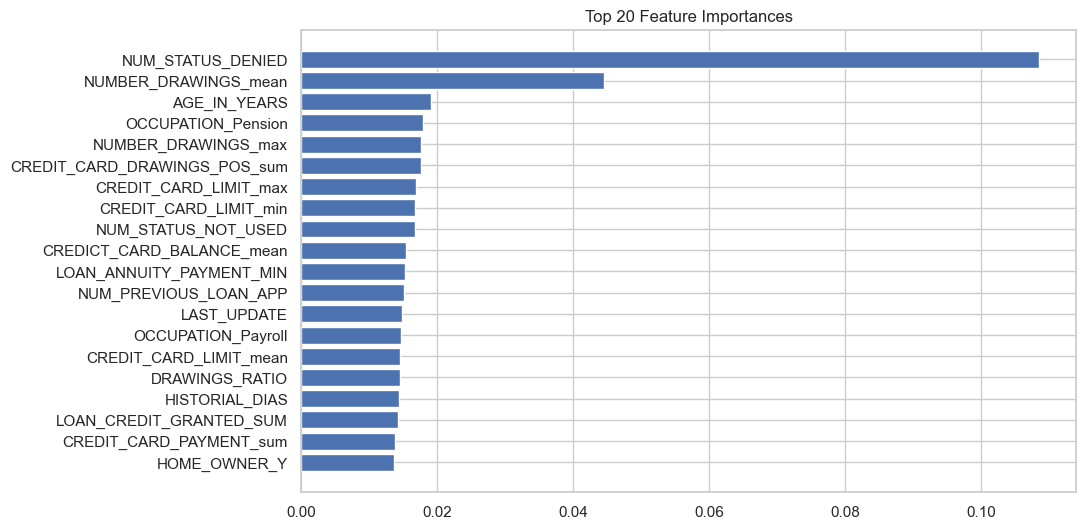

In [99]:
importances = xgb_model.feature_importances_
features = X_train.columns if hasattr(X_train, 'columns') else [f"f{i}" for i in range(X_train.shape[1])]
feat_imp_df = pd.DataFrame({"Feature": features, "Importance": importances})
feat_imp_df = feat_imp_df.sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df["Feature"][:20][::-1], feat_imp_df["Importance"][:20][::-1])
plt.title("Top 20 Feature Importances")
plt.show()

In [100]:
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [101]:
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test  MSE:", mean_squared_error(y_test, y_test_pred))
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test  R2:", r2_score(y_test, y_test_pred))

Train MSE: 0.01120874584887857
Test  MSE: 0.03134315706822948
Train R2: 0.696775666692137
Test  R2: 0.14434909652850947


In [102]:
BEHAVIORAL_SCORING_pred = xgb_model.predict(df_exogenas)

**Añadir Predicciones de Scores en dataframe original**

In [103]:
df_score_pred = df_encoded.copy()

In [104]:
df_score_pred['REACTIVE_SCORING_pred'] = REACTIVE_SCORING_pred
df_score_pred['PROACTIVE_SCORING_pred'] = PROACTIVE_SCORING_pred
df_score_pred['BEHAVIORAL_SCORING_pred'] = BEHAVIORAL_SCORING_pred

In [105]:
scores = ['REACTIVE_SCORING','REACTIVE_SCORING_pred','PROACTIVE_SCORING','PROACTIVE_SCORING_pred','BEHAVIORAL_SCORING','BEHAVIORAL_SCORING_pred']

In [106]:
df_score_pred[scores]

,REACTIVE_SCORING,REACTIVE_SCORING_pred,PROACTIVE_SCORING,PROACTIVE_SCORING_pred,BEHAVIORAL_SCORING,BEHAVIORAL_SCORING_pred
0,NaN,0.323165,0.264443,0.338119,0.524496,0.579662
1,0.607521,0.598112,0.699410,0.634125,0.698668,0.601182
2,NaN,0.650164,0.314247,0.447533,0.231439,0.448860
3,0.781124,0.659514,0.689406,0.639529,0.670652,0.601655
4,NaN,0.554094,0.141431,0.519296,NaN,0.558644
...,...,...,...,...,...,...
46041,0.662585,0.538190,0.582618,0.502806,0.528093,0.562168
46042,NaN,0.629267,0.711468,0.516131,0.401407,0.546429
46043,0.340650,0.494250,0.573306,0.534165,0.681706,0.581285
46044,NaN,0.442006,0.305907,0.407489,NaN,0.395088


In [107]:
cols = ['REACTIVE_SCORING', 'PROACTIVE_SCORING', 'BEHAVIORAL_SCORING']

for col in cols:
    pred_col = col + '_pred'
    # Solo reemplazar donde el original es NaN con el valor predicho
    df_score_pred[col] = df_score_pred[col].fillna(df_score_pred[pred_col])

In [108]:
df_score_pred[scores]

,REACTIVE_SCORING,REACTIVE_SCORING_pred,PROACTIVE_SCORING,PROACTIVE_SCORING_pred,BEHAVIORAL_SCORING,BEHAVIORAL_SCORING_pred
0,0.323165,0.323165,0.264443,0.338119,0.524496,0.579662
1,0.607521,0.598112,0.699410,0.634125,0.698668,0.601182
2,0.650164,0.650164,0.314247,0.447533,0.231439,0.448860
3,0.781124,0.659514,0.689406,0.639529,0.670652,0.601655
4,0.554094,0.554094,0.141431,0.519296,0.558644,0.558644
...,...,...,...,...,...,...
46041,0.662585,0.538190,0.582618,0.502806,0.528093,0.562168
46042,0.629267,0.629267,0.711468,0.516131,0.401407,0.546429
46043,0.340650,0.494250,0.573306,0.534165,0.681706,0.581285
46044,0.442006,0.442006,0.305907,0.407489,0.395088,0.395088


In [109]:
df_score_pred.drop(columns=['REACTIVE_SCORING_pred',"PROACTIVE_SCORING_pred","BEHAVIORAL_SCORING_pred"], inplace=True)

**6. Over Sample**

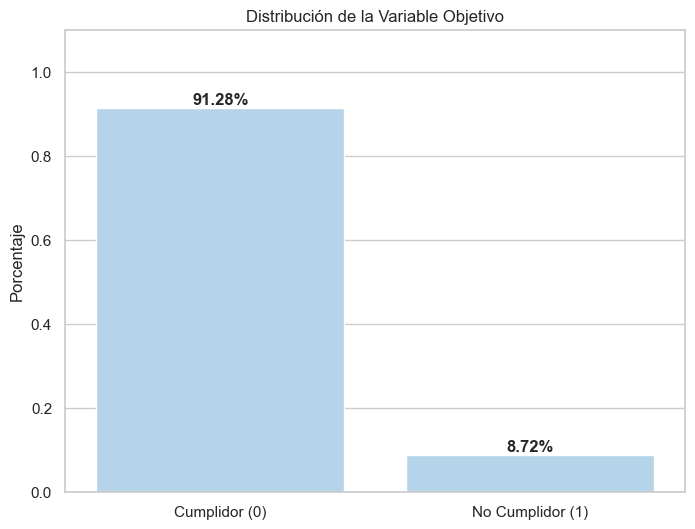

In [110]:
# Calcular proporciones
proportions = df_score_pred['NON_COMPLIANT_CONTRACT'].value_counts(normalize=True).sort_index()
labels = ['Cumplidor (0)', 'No Cumplidor (1)']

# Graficar con un solo color y sin 'palette'
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=labels, y=proportions.values, color='#AED6F1')  # azul claro

# Etiquetas
for i, v in enumerate(proportions.values):
    ax.text(i, v + 0.01, f"{v*100:.2f}%", ha='center', fontweight='bold')

plt.title('Distribución de la Variable Objetivo')
plt.ylabel('Porcentaje')
plt.ylim(0, 1.1)
plt.show()

In [111]:
X = df_score_pred.drop(columns='NON_COMPLIANT_CONTRACT')
y = df_score_pred['NON_COMPLIANT_CONTRACT']

In [112]:
###### Ajustar proporción: minoría será 30% del total
smote = SMOTE(sampling_strategy=0.8, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

C:\wokspace_github\Perfil-clientes\venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [113]:
df_balanceado = X_res.copy()
df_balanceado['NON_COMPLIANT_CONTRACT'] = y_res

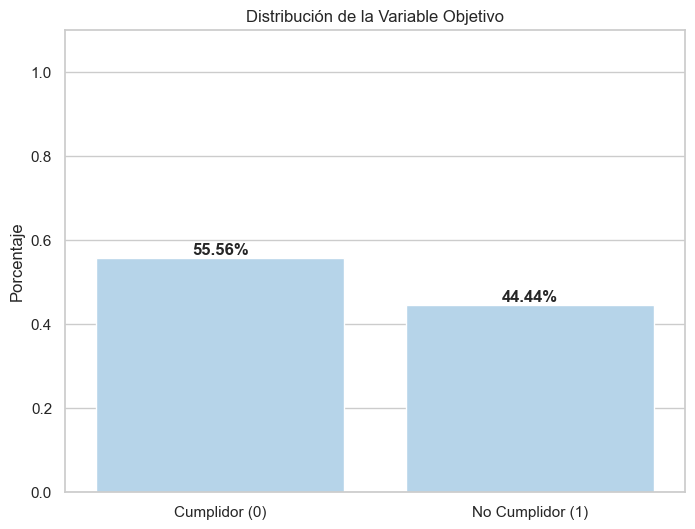

In [114]:
# Calcular proporciones
proportions = df_balanceado['NON_COMPLIANT_CONTRACT'].value_counts(normalize=True).sort_index()
labels = ['Cumplidor (0)', 'No Cumplidor (1)']

# Graficar con un solo color y sin 'palette'
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=labels, y=proportions.values, color='#AED6F1')  # azul claro

# Etiquetas
for i, v in enumerate(proportions.values):
    ax.text(i, v + 0.01, f"{v*100:.2f}%", ha='center', fontweight='bold')

plt.title('Distribución de la Variable Objetivo')
plt.ylabel('Porcentaje')
plt.ylim(0, 1.1)
plt.show()

In [115]:
df_balanceado.to_parquet(os.path.join(output_data,"credit_card_balanceado.parquet"), index=False)

**7. Encontrar valores atipicos**

In [116]:
# 1. Separa variables predictoras y objetivo

X = df_balanceado.drop('NON_COMPLIANT_CONTRACT', axis=1)
y = df_balanceado['NON_COMPLIANT_CONTRACT']

In [117]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(X)

In [118]:
mask = outliers == 1  # Filtramos solo los datos normales

# 3. Filtra X y y
X_clean = X[mask]
y_clean = y[mask]

In [119]:
print(f"Antes: {X.shape[0]} filas, Después: {X_clean.shape[0]} filas")

Antes: 75652 filas, Después: 71869 filas


In [120]:
df_clean = X_clean.copy()
df_clean['NON_COMPLIANT_CONTRACT'] = y_clean

In [121]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

In [122]:
# Crear DataFrame con los resultados de PCA y etiquetas de anomalía
df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Anomaly': outliers
})

In [123]:
# Mapea 1 -> Normal, -1 -> Outlier
df_plot['Anomaly'] = df_plot['Anomaly'].map({1: 'Normal', -1: 'Outlier'})

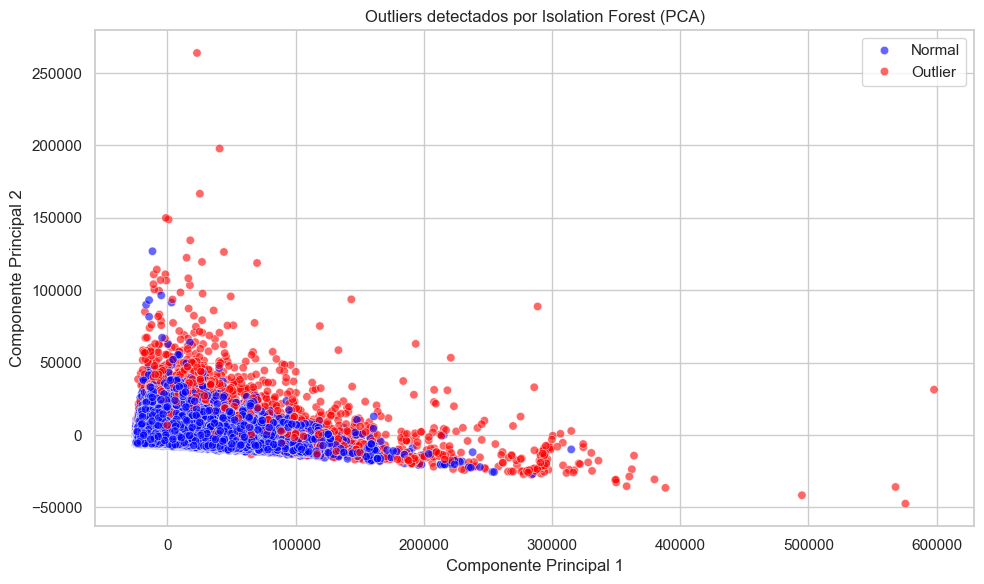

In [124]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x='PC1', y='PC2',
    hue='Anomaly',
    palette={'Normal': 'blue', 'Outlier': 'red'},
    alpha=0.6
)
plt.title('Outliers detectados por Isolation Forest (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.tight_layout()
plt.show()

In [125]:
df_clean.shape

(71869, 77)

**8. Ajuste de modelos**

In [126]:
df_clean.head()

,TOTAL_INCOME,AMOUNT_PRODUCT,INSTALLMENT,REGION_SCORE,AGE_IN_YEARS,JOB_SENIORITY,HOME_SENIORITY,LAST_UPDATE,FAMILY_SIZE,REACTIVE_SCORING,...,HOME_SITUATION_Public housing,HOME_SITUATION_Rented apartment,HOME_SITUATION_Small studio,OWN_INSURANCE_CAR_Y,OCCUPATION_Payroll,OCCUPATION_Pension,OCCUPATION_Students,OCCUPATION_Unemploy,HOME_OWNER_Y,NON_COMPLIANT_CONTRACT
0,1350.0,3234.60,298.24,0.005084,34.320548,390.0,6610.0,4362.0,1.0,0.323165,...,0,0,0,0,1,0,0,0,1,0
1,1620.0,4890.24,386.37,0.046220,40.652055,1681.0,56.0,4992.0,1.0,0.607521,...,0,0,0,0,1,0,0,0,0,0
2,2430.0,5004.29,242.30,0.059364,61.331507,597.0,8937.0,5764.0,2.0,0.650164,...,0,0,0,0,1,0,0,0,1,0
3,1080.0,15522.03,455.38,0.022625,40.219178,1106.0,7950.0,4683.0,4.0,0.781124,...,0,0,0,0,1,0,0,0,1,0
4,2430.0,11634.95,619.87,0.001276,46.410959,4640.0,8958.0,475.0,2.0,0.554094,...,0,0,0,0,1,0,0,0,1,1


**Evaluar modelos**

In [127]:
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

In [128]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [4, 6],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

In [129]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',  # Aquí elige la métrica para refit, debe ser una clave de scoring
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X, y)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


C:\wokspace_github\Perfil-clientes\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:03:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importanc...
             param_grid={'colsample_bytree': [0.6, 0.8],
                         'learning_rate': [0.01, 0.05], 'max_depth': [4, 6],
                         'n_estimators': [100, 300], 'reg_alpha': [0, 0.1],
                         'reg_lambda': [1, 1.5], 'subsample': [0.6, 0.8]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy',
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict'),
                      'roc_auc': 'roc_auc'},
             verbose=2)

In [130]:
# Resultados promedio en CV
results = grid_search.cv_results_

In [131]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

print("\nMétricas promedio CV para cada combinación:")
for mean_roc_auc, mean_acc, mean_prec, mean_rec, params in zip(
    results['mean_test_roc_auc'], 
    results['mean_test_accuracy'], 
    results['mean_test_precision'], 
    results['mean_test_recall'], 
    results['params']
):
    print(f"ROC_AUC: {mean_roc_auc:.4f}, Accuracy: {mean_acc:.4f}, Precision: {mean_prec:.4f}, Recall: {mean_rec:.4f} con params: {params}")

# Modelo final con mejores parámetros
best_model = grid_search.best_estimator_

Mejores parámetros encontrados:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.6}

Métricas promedio CV para cada combinación:
ROC_AUC: 0.9234, Accuracy: 0.8452, Precision: 0.8986, Recall: 0.7345 con params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.6}
ROC_AUC: 0.9214, Accuracy: 0.8420, Precision: 0.8942, Recall: 0.7309 con params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
ROC_AUC: 0.9232, Accuracy: 0.8449, Precision: 0.8983, Recall: 0.7341 con params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.6}
ROC_AUC: 0.9208, Accuracy: 0.8415, Precision: 0.8934, Recall: 0.7306 con params: {'colsample_bytree': 0.6, 'learning_rate': 0.01

C:\Users\renev\AppData\Local\Temp\ipykernel_200\4164134895.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp.head(20), palette='viridis')


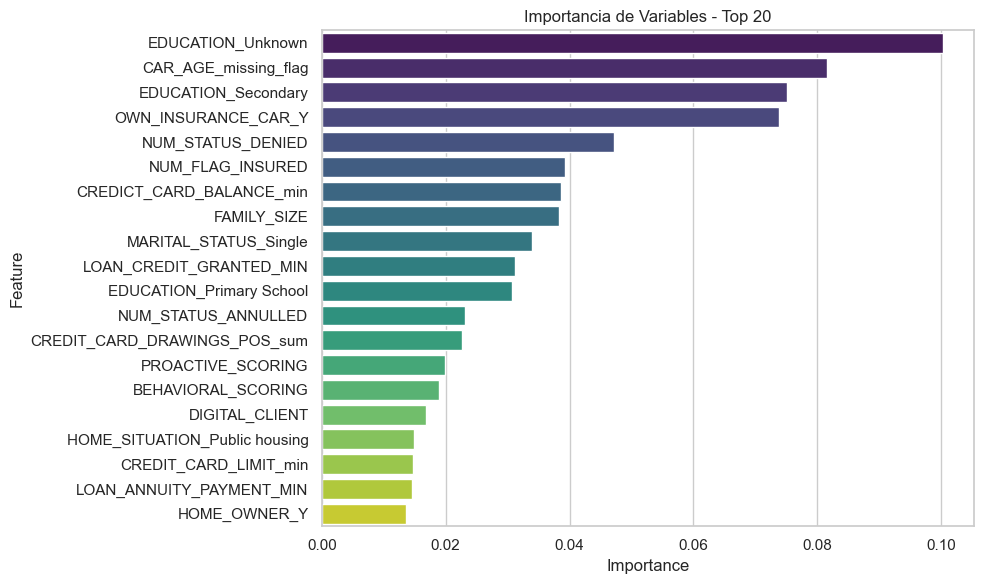

In [132]:
# Obtiene importancias
importances = best_model.feature_importances_
features = X.columns

# Crea un DataFrame ordenado por importancia
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(20), palette='viridis')
plt.title('Importancia de Variables - Top 20')
plt.tight_layout()
plt.show()

**Guardar el modelo final**

In [133]:
# Nombre del archivo
filename = f'perfil_cliente.pkl'

# Ruta completa
filepath = os.path.join(output_data, filename)

In [134]:
# Guarda el modelo final en un archivo
joblib.dump(best_model, filepath)

['C:\\wokspace_github\\Data\\output_data\\perfil_cliente.pkl']